# Presentation Algorithme

# Class preparation Data

Le coude source est disponible [ici](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/inpi_insee/preparation_data.py) et le notebook pour lancer le programme est disponible [ici](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/Preparation_data.ipynb)

## INSEE

Les données sources de l'INSEE proviennent de [Data Gouv](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/)

- communes_insee:
    - Le fichier source pour les communes se trouvent à cette [URL](https://www.insee.fr/fr/information/3720946)
    - Le notebook pour reconstituer le csv est disponible a cette [URL](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/Source_intermediates.ipynb). ⚠️ Repo privé + branche
- voie:
    - Le fichier source pour les communes se trouvent à cette [URL](https://www.sirene.fr/sirene/public/variable/libelleVoieEtablissement)
    - Le notebook pour reconstituer le csv est disponible a cette [URL](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/Source_intermediates.ipynb). ⚠️ Repo privé + branche
- upper_word:
    - La liste des upper word (stop word capitalisé) provient de la librarie [NLTK](https://www.nltk.org/) avec un ajout manuel.
    
## INPI 

Les données de l'INPI proviennent de ses différents Notebooks:

- [inpi_etb](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/Source_intermediates.ipynb)

## Normalisation du fichier INPI.

Le fichier INPI doit contenir un seul fichier gz avant d'être ingéré par le programme. Le fichier va être importé dans un format Dask, ce qui permet de paralléliser les calculs et bien sur d'éviter les problèmes de mémoire. 

La normalisation du fichier de l'INPI se fait en plusieurs étapes:

1) Exclusion des observations avec des NaN pour chacune des variables candidates, à savoir:

    - Adresse_Ligne1
    - Adresse_Ligne2
    - Adresse_Ligne3
    - Code_Postal
    - Ville
    - Code_Commune
2) Extraction des SIREN a SIRETISER -> cela evite d'utiliser toute la base INSEE pour la sirétisation. I.e Speedup le process
3) Calcul du nombre de SIRET par SIREN via la fonction `nombre_siret_siren`
4) Normalisation de la variable commune via la fonction `clean_commune`

    - Extraction des digits dans la ville. En effet, certaines communes incluent l'arrondissement dans la variable.
    - Extraction des caractères spéciaux et espaces
    - Capitalisation du nom de la commune
    - Matching avec le fichier commune pour avoir le nom de la commune de l'INSEE.
5) Préparation de l'adresse via la fonction `prepare_adress`
    - Concatenation des variables `Adresse_Ligne1` + `Adresse_Ligne2` + `Adresse_Ligne3`
    - Normalisation de la variable concatenée -> Extraction des caractères speciaux, espace, digit puis capitalisation
    - Extraction de tous les stop words du fichier `upper_word`
    - Split de chaque mot restant de l'adresse 
    - Creation du regex de la forme suivante:  `MOT1$|MOT2$` 
    - Extration des digits:
        - Première variable avec le premier digit
        - Seconde variable avec une liste de digit et jointure -> DIGIT1|DIGIT2
    - Merge avec le fichier `voie` pour obtenir le type de voie de l'INSEE
    - Calcul du nombre de digit dans l'adresse
        - Si len inférieure a 2, alors NaN. C'est une variable utlisée pendant le matching des règles spéciales
    - Creation d'une variable `index` correspondant à l'index du dataframe. Indispensable
 
Le fichier est sauvegardé en format gz, et dans un table SQL

    - inpi_etb_stock_0.gz
    - inpi_origine.db
    
Un appercu de la table est disponible via cette application `App_inpi`.

## Normalisation du fichier INSEE

Pour l'étape de siretisation, les variables candidates sont les suivantes:

- 'siren',
- 'siret',
- "etablissementSiege",
- "etatAdministratifEtablissement",
- "numeroVoieEtablissement",
- "indiceRepetitionEtablissement",
- "typeVoieEtablissement",
- "libelleVoieEtablissement",
- "complementAdresseEtablissement",
- "codeCommuneEtablissement",
- "libelleCommuneEtablissement",
- "codePostalEtablissement",
- "codeCedexEtablissement",
- "libelleCedexEtablissement",
- "distributionSpecialeEtablissement",
- "libelleCommuneEtrangerEtablissement",
- "codePaysEtrangerEtablissement",
- "libellePaysEtrangerEtablissement",
- "dateCreationEtablissement"

Comme pour le fichier de l'INPI, le fichier csv est importé en Dask Dataframe. Les étapes sont les suivantes:

1) Filtre les SIREN à sirétiser uniquement

2) Filtre la date limite à l'INSEE. Cette étape sert essentiellement pour siretiser les bases de stocks. Cela évite d'utiliser des valeurs "dans le future" -> inconnues à l'INPI

3) Remplacement des "-" par des " " dans la variable `libelleCommuneEtablissement`

4) Extraction des digits en format "liste" de la variable `libelleVoieEtablissement`

5) Calcul du nombre de SIRET par SIREN

6) Calcul du nombre de digit dans la variable `libelleCommuneEtablissement`

    - Si len inférieure a 2, alors NaN. C'est une variable utlisée pendant le matching des règles spéciales
    
Le fichier est sauvegardé en format gz, et dans un table SQL

    - insee_2017_SIZE.gz
    - App_insee.db
    
Un appercu de la table est disponible via cette application `App_insee`.

# Algorithme Siretisation

Le code source est disponible [ici](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/inpi_insee/siretisation.py) et le notebook pour lancer le programme est disponible [ici](https://github.com/thomaspernet/InseeInpi_matching/blob/dev_thomas/Notebooks_matching/programme_matching/Siretisation.ipynb)

L'algorithme de SIRETISATION fonctionne avec l'aide de trois fonctions:

- `step_one`: permet d'écarter les doublons du merge et d'appliquer les premières règles afin de connaitre l'origine de la siretisation
- `step_two_assess_test`: détermine l'origine du matching, a savoir la date, adresse, voie, numéro de voie
- `step_two_duplication`: permet de récuperer des SIRET sur les doublons émanant du merge avec l'INSEE

Dans premier temps, on créer un dictionnaire avec toutes les variables de matching. Toutefois, l'algorithme va utiliser séquentiellement les variables suivantes:

```
 {'ncc', 'Code_Postal', 'Code_Commune', 'INSEE', 'digit_inpi'},
 {'ncc', 'Code_Postal', 'Code_Commune', 'INSEE'},
 {'ncc', 'Code_Postal', 'Code_Commune', 'digit_inpi'},
 {'ncc', 'Code_Postal', 'Code_Commune'},   
 {'ncc', 'Code_Postal'},
 {'ncc'},
 {'Code_Postal'},
 {'Code_Commune'}
```

Pour connaitre l'ensemble des variables de matching INSEE/INPI, veuillez vous rendre en [annexe](#annexe).

Dans la mesure ou l'algorithme fonctionne de manière séquentielle, et utilise comme input un fichier de l'INPI a siretiser. De fait, après chaque séquence, l'algorithme sauvegarde un fichier gz contenant les siren a trouver. Cette étape de sauvegarde en gz permet de loader le fichier gz en input en Dataframe Dask.

## Step One

La première étape de la séquence est l'ingestion d'un fichier gz contenant les SIREN a trouver. L'ingestion va se faire en convertissant le dataframe en Dask. L'algorithme tout d'abord utiliser la fonction `step_one` et produit deux dataframes selon si le matching avec l'INSEE a débouté sur des doublons ou non. 

Les doublons sont générés si pour un même nombre de variables de matching, il existe plusieurs possibilités à l'INSEE. Par exemple, pour un siren, ville, adressse donnée, il y a plusieurs possibilités. Cela constitue un doublon et il sera traité ultérieurement, dans la mesure du possible. 

Les étapes déroulées lors du premier processus est le suivant:

```
- Test 1: doublon
        - non: Save-> `test_1['not_duplication']`
        - oui:
            - Test 2: Date equal
                - oui:
                    - Test 2 bis: doublon
                        - non: Save-> `test_2_bis['not_duplication']`
                        - oui: Save-> `test_2_bis['duplication']`
                - non:
                    - Test 3: Date sup
                        - oui:
                            - Test 2 bis: doublon
                                - non: Save-> `test_3_oui_bis['not_duplication']`
                                - oui: Save-> `test_3_oui_bis['duplication']`
                        - non: Save-> `test_3_non`
```

Deux dataframe sont crées, un ne contenant pas de doublon et un deuxième contenant les doublons. L'algorithme va réaliser les tests sur le premier et faire d'avantage de recherche sur le second.

## step_two_assess_test

Le premier dataframe ne contient pas de doublon, il est donc possible de réaliser différents tests afin de mieux déterminerl'origine du matching. Plus précisement, si le matching a pu se faire sur la date, l'adresse, la voie, numéro de voie et le nombre unique d'index. Les règles sont définies ci-dessous.

```
- Test 1: address libelle
            - Si mots dans inpi est contenu dans INSEE, True
        - Test 1 bis: address complement
            - Si mots dans inpi est contenu dans INSEE, True
        - Test 2: Date
            - dateCreationEtablissement >= Date_Début_Activité OR
            Date_Début_Activité = NaN OR (nombre SIREN a l'INSEE = 1 AND nombre
            SIREN des variables de matching = 1), True
        - Test 3: siege
            - Type = ['SEP', 'SIE'] AND siege = true, True
        - Test 4: voie
            - Type voie INPI = Type voie INSEE, True
        - Test 5: numero voie
            - Numero voie INPI = Numero voie INSEE, True
```

Un premier fichier gz est enregistré contenant les "pure matches"

## step_two_duplication

Les second dataframe contient les doublons obtenus après le matching avec l'INSEE. L'algorithme va travailler sur différentes variables de manière séquentielle pour tenter de trouver les bons SIRET. Plus précisément, 3 variables qui ont été récemment créé sont utilisées:

- test_join_address -> True si la variable test_address_libelle = True (ie mot INPI trouvé dans INSEE) et test_join_address =  True
- test_address_libelle ->  True si la variable test_address_libelle = True (ie mot INPI trouvé dans INSEE)
- test_address_complement -> True si la variable test_join_address =  True

Pour chaque séquence, on réalise les tests suivants:

```
- Si test_join_address = True:
        - Test 1: doublon:
            - Oui: append-> `df_not_duplicate`
            - Non: Pass
            - Exclue les `index` de df_duplication
            - then go next
        - Si test_address_libelle = True:
            - Test 1: doublon:
                - Oui: append-> `df_not_duplicate`
                - Non: Pass
                - Exclue les `index` de df_duplication
                - then go next
        - Si test_address_complement = True:
            - Test 1: doublon:
                - Oui: append-> `df_not_duplicate`
                - Non: Pass
                - Exclue les `index` de df_duplication
 ```
 
On peut sauvegarder le `df_not_duplicate` et le restant en tant que `special_treatment`


![](https://www.lucidchart.com/publicSegments/view/5a8cb28f-dc42-4708-babd-423962514878/image.png)



# Algorithme

In [ ]:
list_inpi = ['ncc','Code_Postal','Code_Commune','INSEE','digit_inpi']
list_insee = ['libelleCommuneEtablissement',
            'codePostalEtablissement', 'codeCommuneEtablissement',
            'typeVoieEtablissement','numeroVoieEtablissement']

sort_list = [
 {'ncc', 'Code_Postal', 'Code_Commune', 'INSEE', 'digit_inpi'},
 {'ncc', 'Code_Postal', 'Code_Commune', 'INSEE'},
 {'ncc', 'Code_Postal', 'Code_Commune', 'digit_inpi'},
 {'ncc', 'Code_Postal', 'Code_Commune'},   
 {'ncc', 'Code_Postal'},
 {'ncc'},
 {'Code_Postal'},
 {'Code_Commune'}
]

In [ ]:
list_possibilities = []
for i in sort_list:
    left =[]
    right = []
    for j in i:
        left.append(j)
        right.append(list_insee[list_inpi.index(j)])
    left.insert(0,'siren')
    right.insert(0,'siren')
    
    dic_ = {
    'match':{
        'inpi':left,
        'insee':right,
    }
}
    list_possibilities.append(dic_)
list_possibilities

In [ ]:
import json
inpi_col = ['siren',
            'index',
            'Type',
            'Code_Postal',
            'Ville',
            'Code_Commune',
            'Pays',
            'count_initial_inpi',
            'ncc',
            'Adresse_new_clean_reg',
            'Adress_new',
            'INSEE',
            'Date_Début_Activité',
            'digit_inpi',
            'len_digit_address_inpi',
            'list_digit_inpi'
            ]

inpi_dtype = {
    'siren': 'object',
    'index': 'int',
    'Type': 'object',
    'Code_Postal': 'object',
    'Ville': 'object',
    'Code_Commune': 'object',
    'Pays': 'object',
    'count_initial_inpi': 'int',
    'ncc': 'object',
    'Adresse_new_clean_reg': 'object',
    'Adress_new':'object',
    'INSEE': 'object',
    'Date_Début_Activité': 'object',
    'digit_inpi': 'object',
    'len_digit_address_inpi':'object'
}

Ici, on va faire l'exemple sur un fichier INPI créer au cours de la troisième séquence. 

In [4]:
from inpi_insee import siretisation
%load_ext autoreload
%autoreload 2

param = {
    'insee': r'data\input\INSEE\insee_2017_7627977.gz'
}
al_siret = siretisation.siretisation_inpi(param)

C:\Users\PERNETTH\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
df_ets = r'data\input\INPI\inpi_etb_stock_{}.gz'.format(2)
inpi = al_siret.import_dask(file=df_ets,
                                usecols=inpi_col,
                                dtype=inpi_dtype,
                                parse_dates=False)

In [6]:
inpi.head()

[########################################] | 100% Completed |  8.9s


,siren,Date_Début_Activité,count_initial_inpi,Type,Pays,Ville,ncc,Code_Postal,Code_Commune,Adress_new,Adresse_new_clean_reg,INSEE,digit_inpi,list_digit_inpi,len_digit_address_inpi,index
0,384684437,1992-01-15,1,SEP,FRANCE,Trévoux,TREVOUX,01600,01347,LA GRAVIERE SAINT DIDIER DE FORMANS,GRAVIERE$|SAINT$|DIDIER$|FORMANS$,NaN,NaN,NaN,0,5
1,824659734,2016-11-28,1,SEP,FRANCE,Miribel,MIRIBEL,01706,01249,836 ROUTE DE TRAMOYES LES ECHETS,TRAMOYES$|ECHETS$,RTE,836,NaN,1,10
2,442377040,2002-07-01,2,PRI,FRANCE,Buellas,BUELLAS,01310,NaN,200 ROUTE DE TREVOUX,TREVOUX$,RTE,200,NaN,1,15
3,442377040,2015-06-01,2,SEC,FRANCE,Saint-André-sur-Vieux-Jonc,SAINT ANDRE SUR VIEUX JONC,01960,01336,300 RUE DE LA MAIRIE,MAIRIE$,RUE,300,NaN,1,16
4,814101168,2015-01-01,1,SEP,FRANCE,Etrez,ETREZ,01340,01154,1453 ROUTE DE FOISSIAT LIEUDIT LA SPIRE,FOISSIAT$|LIEUDIT$|SPIRE$,RTE,1453,NaN,1,17


Pour la première étape, on va matcher avec les variables suivante à l'INPI et à l'INSEE

Variables a l'INPI

In [7]:
list_possibilities[2]['match']['inpi']

['siren', 'Code_Postal', 'ncc', 'Code_Commune', 'digit_inpi']

Variables a l'INSEE

In [8]:
list_possibilities[2]['match']['insee']

['siren',
 'codePostalEtablissement',
 'libelleCommuneEtablissement',
 'codeCommuneEtablissement',
 'numeroVoieEtablissement']

## Step One:  Merge 2 Dataframes

Le code va produire deux dataframes, un premier sans les doublons et un autre avec les doublons. 

In [9]:
df_no_duplication, df_duplication = al_siret.step_one(
        df_input=inpi,
        left_on=list_possibilities[2]['match']['inpi'],
        right_on=list_possibilities[2]['match']['insee']
    )

[########################################] | 100% Completed |  1min  1.2s


### Etat sur les matchés

Il y a 434488 lignes de matchés, pour un nombre de 324413 de SIREN

In [10]:
df_no_duplication.head()

,siren,Date_Début_Activité,count_initial_inpi,Type,Pays,Ville,ncc,Code_Postal,Code_Commune,Adress_new,...,libelleCommuneEtrangerEtablissement,distributionSpecialeEtablissement,codeCommuneEtablissement,codeCedexEtablissement,libelleCedexEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,etatAdministratifEtablissement,count_duplicates_,origin
0,803282508,2014-07-01,1,SEP,FRANCE,Saint-Martin-du-Frêne,SAINT MARTIN DU FRENE,01430,01373,60 GRANDE RUE,...,NaN,NaN,01373,NaN,NaN,NaN,NaN,A,1,test_1_no_duplication
1,422812610,1999-06-30,2,SEP,FRANCE,Viriat,VIRIAT,01440,01451,400 CHEMIN DE LA CRAZ,...,NaN,NaN,01451,NaN,NaN,NaN,NaN,A,1,test_1_no_duplication
2,819942400,2016-05-26,1,PRI,FRANCE,Belley,BELLEY,01300,01034,92 GRANDE RUE,...,NaN,NaN,01034,NaN,NaN,NaN,NaN,F,1,test_1_no_duplication
3,493618235,2006-12-22,1,SEP,FRANCE,PONT DE VEYLE,PONT DE VEYLE,01290,01306,50 GRANDE RUE,...,NaN,NaN,01306,NaN,NaN,NaN,NaN,A,1,test_1_no_duplication
4,823065305,2016-10-01,2,SEP,FRANCE,Seyssel,SEYSSEL,74910,74269,2 QUAI DU RHONE,...,NaN,NaN,74269,NaN,NaN,NaN,NaN,F,1,test_1_no_duplication


### Etat sur les doublons

Il y a 5424 lignes de doublons, pour un nombre de 1821 de SIREN

In [11]:
df_duplication.head()

,siren,Date_Début_Activité,count_initial_inpi,Type,Pays,Ville,ncc,Code_Postal,Code_Commune,Adress_new,...,libelleCommuneEtrangerEtablissement,distributionSpecialeEtablissement,codeCommuneEtablissement,codeCedexEtablissement,libelleCedexEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,etatAdministratifEtablissement,count_duplicates_,origin
3,480470152,2007-01-31,254,SEC,FRANCE,Brest,BREST,29200,29019,ROUTE DE GOUESNOU RD PT DE KERGARADEC ZONE D ...,...,NaN,NaN,29019,NaN,NaN,NaN,NaN,A,2,test_2_duplication
4,480470152,2007-01-31,254,SEC,FRANCE,Brest,BREST,29200,29019,ROUTE DE GOUESNOU RD PT DE KERGARADEC ZONE D ...,...,NaN,NaN,29019,NaN,NaN,NaN,NaN,A,2,test_2_duplication
5,480470152,2007-01-31,254,SEC,FRANCE,Bordeaux,BORDEAUX,33300,33063,CENTRE COMMERCIAL AUCHAN,...,NaN,NaN,33063,NaN,NaN,NaN,NaN,A,2,test_2_duplication
6,480470152,2007-01-31,254,SEC,FRANCE,Bordeaux,BORDEAUX,33300,33063,CENTRE COMMERCIAL AUCHAN,...,NaN,NaN,33063,NaN,NaN,NaN,NaN,F,2,test_2_duplication
7,342122546,2015-06-21,52,SEC,France,Beauvais,BEAUVAIS,60000,60057,LE BOIS QUEQUET ROUTE DE BEAUVAIS A BERNEUIL,...,NaN,NaN,60057,NaN,NaN,NaN,NaN,A,2,test_2_duplication


## Step 2: No duplication

Creation des tests pour connaitre la/les méthodes de matching.

Pour rappel, les tests sont les suivants:

- 'test_address_libelle',
- 'test_address_complement',
- 'test_join_address',
- 'test_date',
- 'test_1',
- 'test_siege',
- 'test_voie',
- 'test_numero'
- 'count_duplicates_final'
- len_digit_address_insee : optional

In [12]:
# Step 2: No duplication
pure_match = al_siret.step_two_assess_test(
    df=df_no_duplication,
    var_group=list_possibilities[2]['match']['inpi'])

[########################################] | 100% Completed | 37.5s
[########################################] | 100% Completed | 37.6s
[########################################] | 100% Completed |  0.4s


In [13]:
import pandas as pd
temp = pd.read_csv('existing_files.csv')

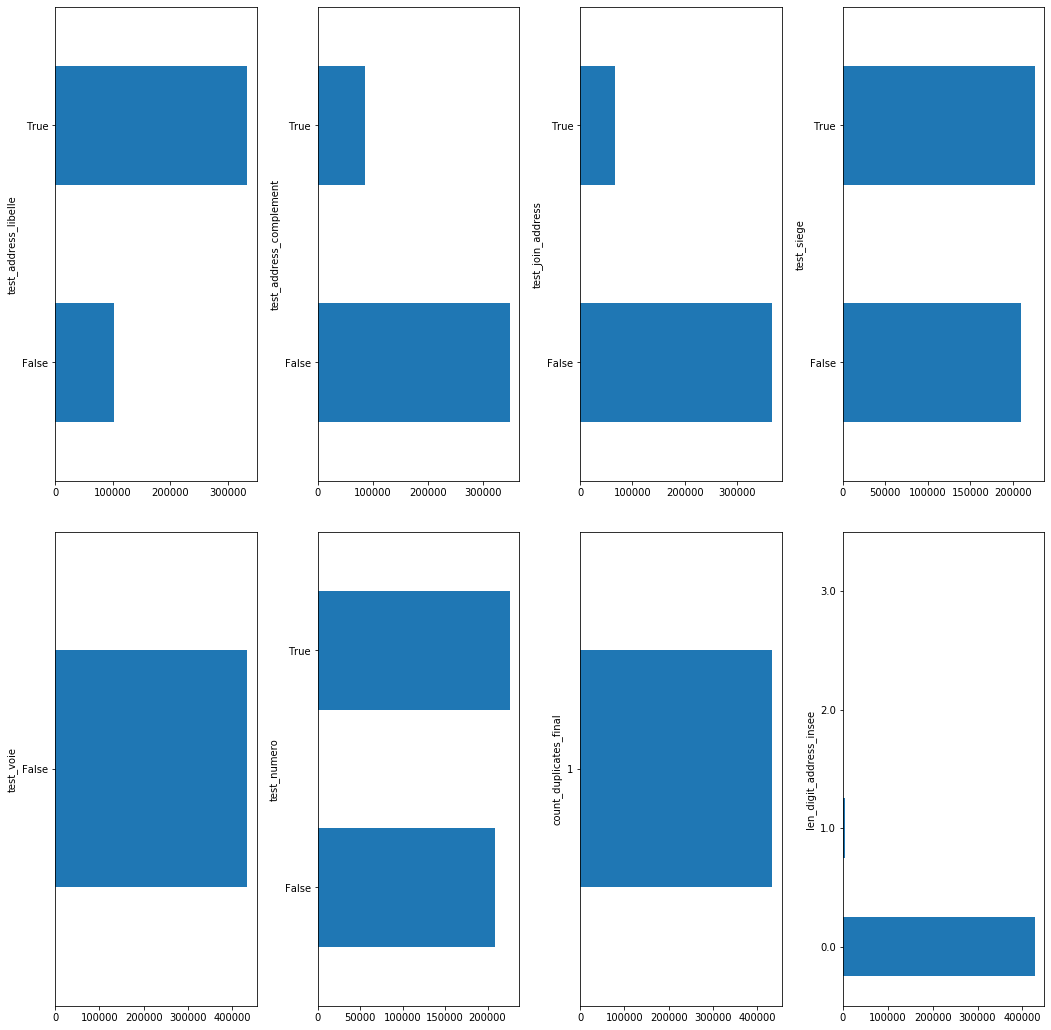

In [14]:
siretisation.create_graph_test(df = pure_match)

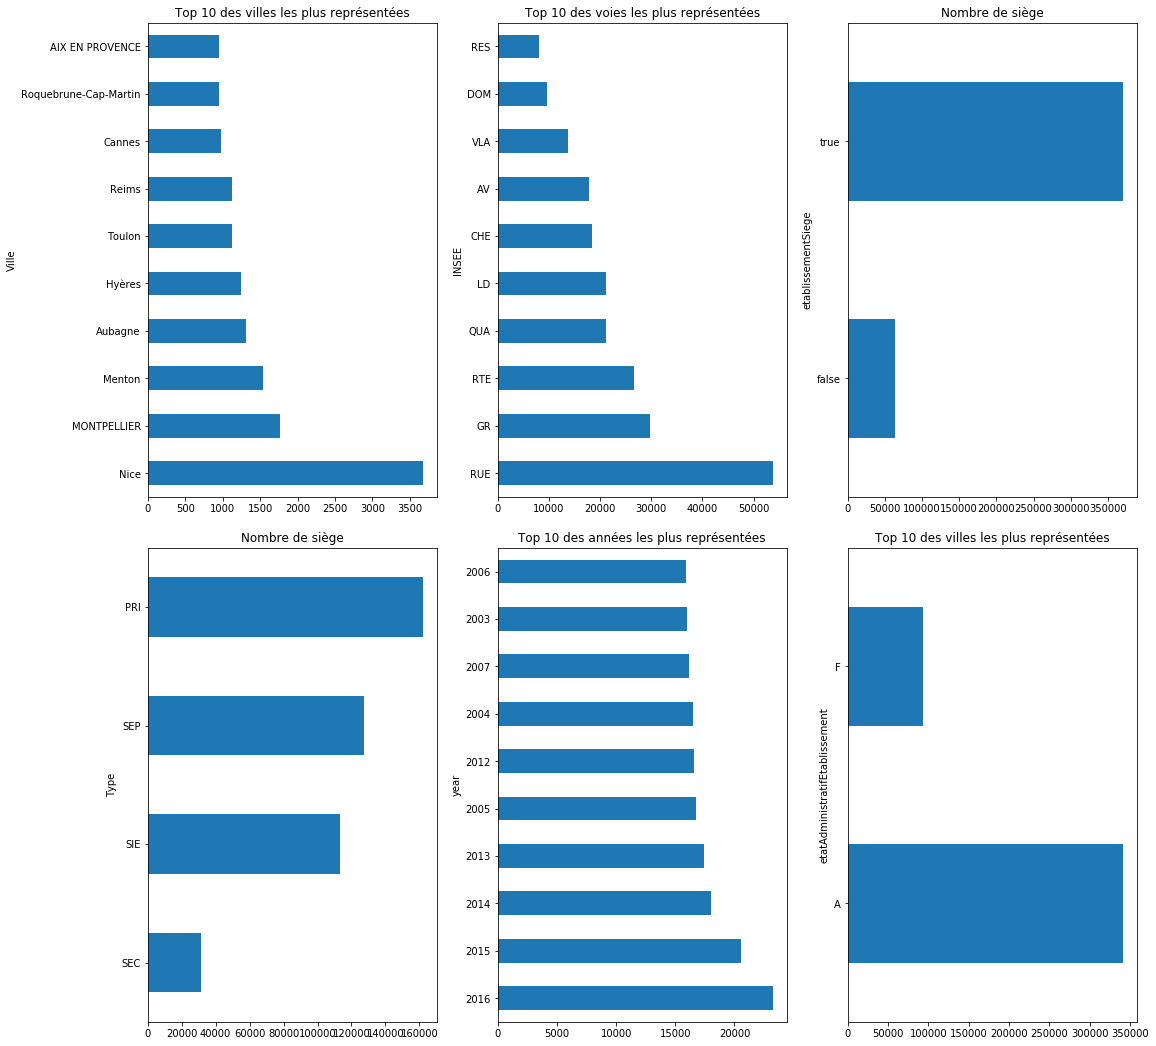

In [15]:
siretisation.create_graph_analysis(df= pure_match)

## Step 2 duplication

In [16]:
# Step 2: duplication
df_not_duplicate, sp = al_siret.step_two_duplication(
    df_duplication,
    var_group = list_possibilities[2]['match']['inpi']
)

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.1s


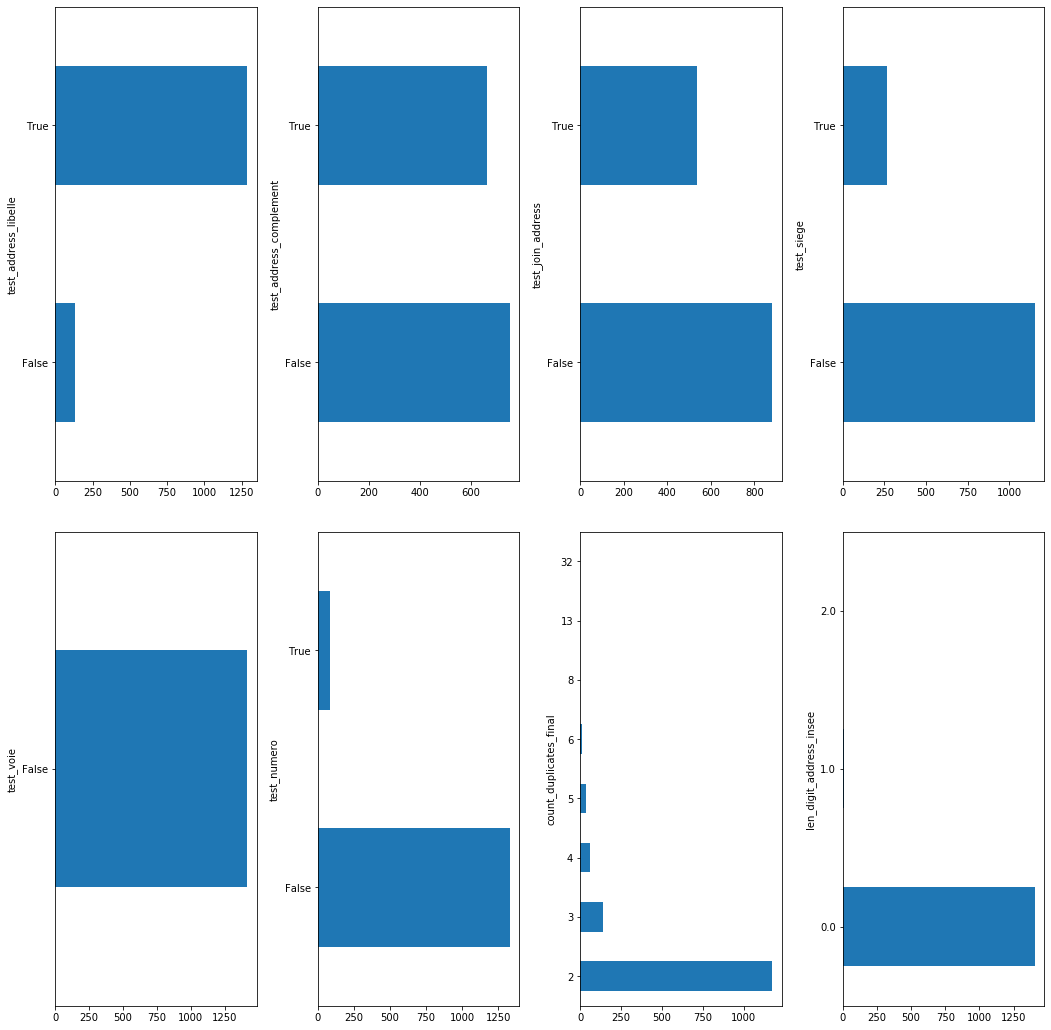

In [17]:
siretisation.create_graph_test(df = df_not_duplicate)

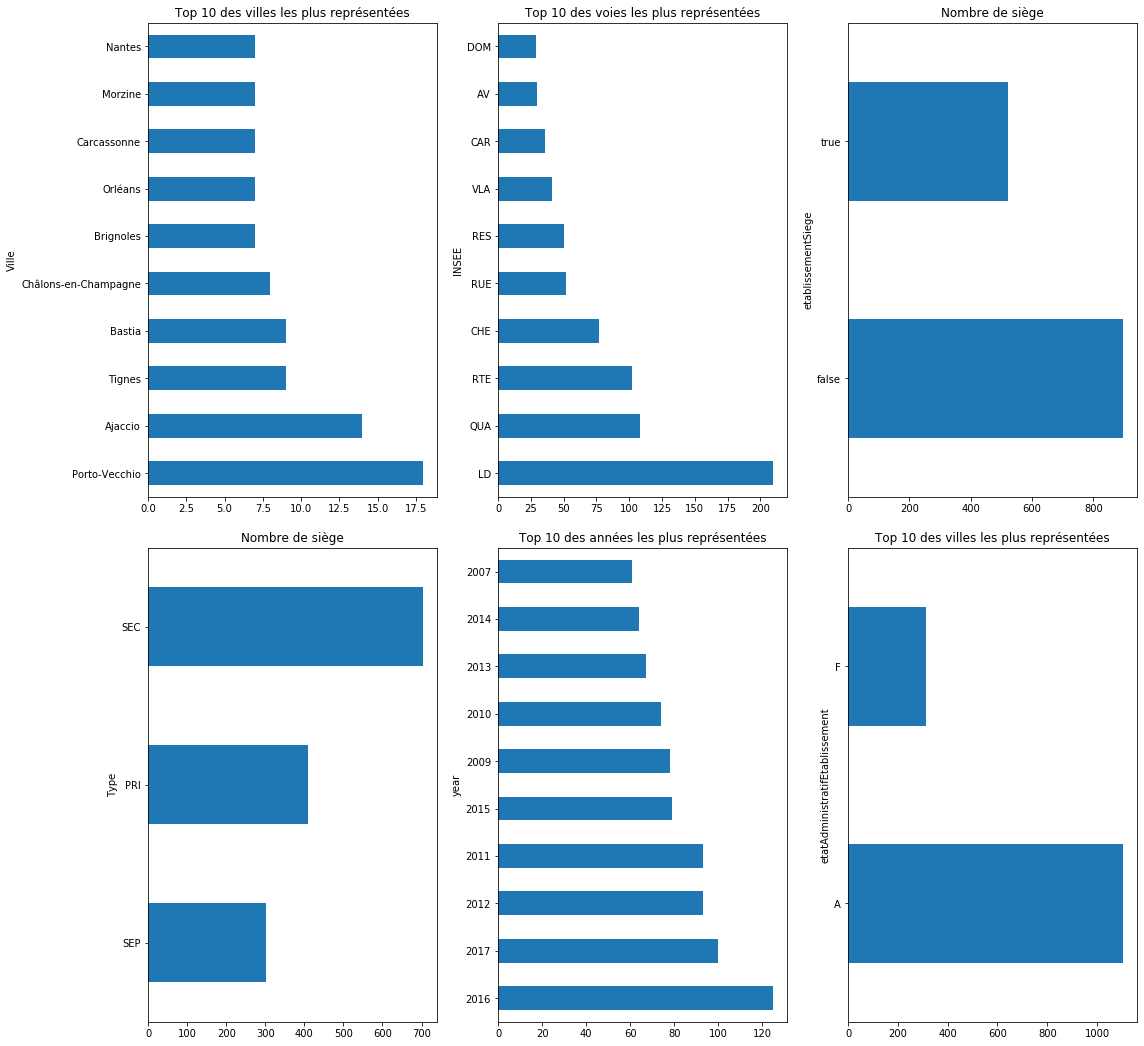

In [18]:
siretisation.create_graph_analysis(df= df_not_duplicate)

In [19]:
sp.head()

,siren,Date_Début_Activité,count_initial_inpi,Type,Pays,Ville,ncc,Code_Postal,Code_Commune,Adress_new,...,count_siren_siret,test_address_libelle,test_address_complement,test_join_address,test_date,test_1,test_siege,test_voie,test_numero,count_duplicates_final
2,480470152,2007-01-31,254,SEC,FRANCE,Bordeaux,BORDEAUX,33300,33063,CENTRE COMMERCIAL AUCHAN,...,NaN,False,False,False,True,NaN,False,False,False,2
3,480470152,2007-01-31,254,SEC,FRANCE,Bordeaux,BORDEAUX,33300,33063,CENTRE COMMERCIAL AUCHAN,...,NaN,False,False,False,True,NaN,False,False,False,2
4,342122546,2015-06-21,52,SEC,France,Beauvais,BEAUVAIS,60000,60057,LE BOIS QUEQUET ROUTE DE BEAUVAIS A BERNEUIL,...,NaN,True,True,True,True,NaN,False,False,False,2
5,342122546,2015-06-21,52,SEC,France,Beauvais,BEAUVAIS,60000,60057,LE BOIS QUEQUET ROUTE DE BEAUVAIS A BERNEUIL,...,NaN,True,True,True,True,NaN,False,False,False,2
14,424442762,2017-03-06,113,SEC,France,Saint-Étienne-de-Lugdarès,SAINT ETIENNE DE LUGDARES,07590,07232,PLATEAU DE CHAM LONGE LE COURBIL,...,NaN,True,True,True,True,NaN,False,False,False,3


## Exemple de reglès spéciales 

### Recuperation via list_digit_ INPI/INSEE

On va utliser la récupération des digits dans l'adresse INPI/INPI qui est pour le moment au format liste, puis vérifier si ils correpondent dans les deux fichiers.

Attention, la technique ne marche que lorsque les digits sont dans le même ordre. Une amélioration via regex va être mise en place ultérieurement.

Dans le fichier ci dessous de traitement spéciale, il y a 1261 SIREN sans SIRET, c'est à dire, que l'algorithme n'est pas sur à 100% du SIRET.

In [20]:
test = pd.read_csv(
        r'data\input\INPI\special_treatment\{}_special_treatment.gz'.format(1),
                   low_memory=False)
#test['siren'].nunique()

Exemple avec le SIREN `752085324`. Dans le fichier `_special_treatment`, il y a plus de 9300 combinaisons possibles pour ce SIREN, pour 97 SIRET. Via la règles spéciale, il est possible de récupérer 86 SIRET.

In [21]:
test.loc[lambda x: 
         x['siren'].isin(['752085324'])
        & (x['list_digit_inpi'] == x['list_digit_insee'])
        ][['Adress_new','libelleVoieEtablissement','list_digit_inpi',
           'list_digit_insee', 'siret']]

,Adress_new,libelleVoieEtablissement,list_digit_inpi,list_digit_insee,siret
32906,LIEU DIT D51 SAINT ESTEVE LOT 2,D51-SAINT ESTEVE-LOT 2,"['51', '2']","['51', '2']",75208532400453
33002,LIEU DIT 51 SAINT ESTEVE LOT 1,D51-SAINT ESTEVE-LOT 1,"['51', '1']","['51', '1']",75208532400446
33101,LIEU DIT D51 SAINT ESTEVE LOT 3,D51-SAINT ESTEVE-LOT 3,"['51', '3']","['51', '3']",75208532400461
33199,LIEU DIT D51 SAINT ESTEVE LOT 4,D51-SAINT ESTEVE-LOT 4,"['51', '4']","['51', '4']",75208532400479
33299,LIEU DIT D51 SAINT ESTEVE LOT 5,D51-SAINT ESTEVE-LOT 5,"['51', '5']","['51', '5']",75208532400503
...,...,...,...,...,...
41722,LIEU DIT RD 11 LAS TRAVESSES LOT 66,RD11-LAS TRAVESSES-LOT 66,"['11', '66']","['11', '66']",75208532400347
41823,LIEU DIT RD 11 LAS TRAVESSES LOT 68,RD11-LAS TRAVESSES-LOT 68,"['11', '68']","['11', '68']",75208532400388
41922,LIEU DIT RD 11 LAS TRAVESSES LOT 69,RD11-LAS TRAVESSES-LOT 69,"['11', '69']","['11', '69']",75208532400404
42021,LIEU DIT RD 11 LAS TRAVESSES LOT 70,RD11-LAS TRAVESSES-LOT 70,"['11', '70']","['11', '70']",75208532400420


# annexe

```
[{'match': {'inpi': ['siren',
    'INSEE',
    'ncc',
    'Code_Postal',
    'Code_Commune',
    'digit_inpi'],
   'insee': ['siren',
    'typeVoieEtablissement',
    'libelleCommuneEtablissement',
    'codePostalEtablissement',
    'codeCommuneEtablissement',
    'numeroVoieEtablissement']}},
 {'match': {'inpi': ['siren', 'ncc', 'Code_Commune', 'Code_Postal', 'INSEE'],
   'insee': ['siren',
    'libelleCommuneEtablissement',
    'codeCommuneEtablissement',
    'codePostalEtablissement',
    'typeVoieEtablissement']}},
 {'match': {'inpi': ['siren',
    'ncc',
    'Code_Commune',
    'Code_Postal',
    'digit_inpi'],
   'insee': ['siren',
    'libelleCommuneEtablissement',
    'codeCommuneEtablissement',
    'codePostalEtablissement',
    'numeroVoieEtablissement']}},
 {'match': {'inpi': ['siren', 'ncc', 'Code_Commune', 'Code_Postal'],
   'insee': ['siren',
    'libelleCommuneEtablissement',
    'codeCommuneEtablissement',
    'codePostalEtablissement']}},
 {'match': {'inpi': ['siren', 'ncc', 'Code_Postal'],
   'insee': ['siren',
    'libelleCommuneEtablissement',
    'codePostalEtablissement']}},
 {'match': {'inpi': ['siren', 'ncc'],
   'insee': ['siren', 'libelleCommuneEtablissement']}},
 {'match': {'inpi': ['siren', 'Code_Postal'],
   'insee': ['siren', 'codePostalEtablissement']}},
 {'match': {'inpi': ['siren', 'Code_Commune'],
   'insee': ['siren', 'codeCommuneEtablissement']}}]
```
